Before we get started, a couple of reminders to keep in mind when using iPython notebooks:

- Remember that you can see from the left side of a code cell when it was last run if there is a number within the brackets.
- When you start a new notebook session, make sure you run all of the cells up to the point where you last left off. Even if the output is still visible from when you ran the cells in your previous session, the kernel starts in a fresh state so you'll need to reload the data, etc. on a new session.
- The previous point is useful to keep in mind if your answers do not match what is expected in the lesson's quizzes. Try reloading the data and run all of the processing steps one by one in order to make sure that you are working with the same variables and data that are at each quiz stage.


## Load Data from CSVs

In [1]:
import unicodecsv

def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

In [2]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

## Fixing Data Types

In [3]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [4]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    engagement_record['account_key'] = engagement_record['acct']
    del engagement_record['acct']
    
daily_engagement[0]

{'account_key': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [5]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

Note when running the above cells that we are actively changing the contents of our data variables. If you try to run these cells multiple times in the same session, an error will occur.

## Investigating the Data

In [6]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.

def rows_and_keys(l):
    rownumber = len(l)
    account_keys = set(item['account_key'] for item in l)
    return rownumber, account_keys

rownumber, account_keys = rows_and_keys(project_submissions)
print("Project submissions", rownumber, len(account_keys))
rownumber, engagement_keys = rows_and_keys(daily_engagement)
print("Engagement", rownumber, len(engagement_keys))
rownumber, enrollment_keys = rows_and_keys(enrollments)
print("Enrollments", rownumber, len(enrollment_keys))

('Project submissions', 3642, 743)
('Engagement', 136240, 1237)
('Enrollments', 1640, 1302)


## Problems in the Data

In [7]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".

## Missing Engagement Records

In [8]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
key_difference = enrollment_keys-engagement_keys
for i in key_difference:
    for enrollment in enrollments:
        if enrollment['account_key'] == i:
            print enrollment
            break
    break

{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 1, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 3, 10, 0, 0), u'days_to_cancel': 59}


## Checking for More Problem Records

In [9]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.
surprising_enrollments = [enrollment['account_key'] for enrollment in enrollments
                          if enrollment['account_key'] in key_difference and enrollment['join_date'] != enrollment['cancel_date']]
print len(surprising_enrollments)
print surprising_enrollments

3
[u'1304', u'1304', u'1101']


## Tracking Down the Remaining Problems

In [10]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [11]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [12]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [13]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.
paid_students = {}

for enrollment in non_udacity_enrollments:
    if enrollment['days_to_cancel'] is None or enrollment['days_to_cancel'] > 7:
        if enrollment['account_key'] not in paid_students or paid_students[enrollment['account_key']] < enrollment['join_date']:
            paid_students[enrollment['account_key']] = enrollment['join_date']

print(len(paid_students))

995


## Getting Data from First Week

In [14]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days >= 0 and time_delta.days < 7

def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data


In [15]:
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

In [16]:
print len(paid_enrollments)
print len(paid_engagement)
print len(paid_submissions)

1293
134549
3618


In [17]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = [
    engagement for engagement in non_udacity_engagement
    if engagement['account_key'] in paid_students.keys() and
    within_one_week(paid_students[engagement['account_key']], engagement['utc_date'])
]
len(paid_engagement_in_first_week)

6919

## Exploring Student Engagement

In [18]:
from collections import defaultdict

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week,
                                   'account_key')

In [19]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data

total_minutes_by_account = sum_grouped_items(engagement_by_account,
                                             'total_minutes_visited')


In [20]:
import numpy as np

def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)

describe_data(total_minutes_by_account.values())


Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


## Debugging Data Analysis Code

In [21]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.
import pprint
for key, time in total_minutes_by_account.items():
    if time >= 10080:
        pprint.pprint(engagement_by_account[key][0:10])

## Lessons Completed in First Week

In [22]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.
lessons_completed_by_account = sum_grouped_items(engagement_by_account,
                                                 'lessons_completed')
describe_data(lessons_completed_by_account.values())
#engagement_by_account.items()[0:2]

Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36


## Number of Visits in First Week

In [23]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.
for key, engagements in engagement_by_account.items():
        for engagement in engagements:
            engagement['has_visited'] = 1 if engagement['num_courses_visited'] > 1 else 0

del total_visited[0]
total_visited = sum_grouped_items(engagement_by_account,
                                'has_visited')
describe_data(total_visited.values())

NameError: name 'total_visited' is not defined

## Splitting out Passing Students

In [24]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

#então eu quero uma lista de engagement da primeira semana dos estudantes que passaram no primeiro
#projeto a qualquer momento
# * eu pego a lista de engajamentos da primeira semana dos estudantes
# * tiro a lista de chaves desses estudantes
account_keys =  set(engagement_by_account.keys())
# * filtro da lista de submissões de projetos apenas aqueles que assigned_rating = PASSED e forem do primeiro projeto
passing_accounts = {submission['account_key'] for submission in non_udacity_submissions
                      if submission['assigned_rating'] in ['PASSED', 'DISTINCTION'] and
                      submission['lesson_key'] in subway_project_lesson_keys}
# * itero pela lista de chaves de estudantes e aquelas que não se encontram na lista de projetos filtrados
#   são adicionados na lista de chaves não passadas
#   aquelas que se encontrarem na lista vão para a lista de chaves passadas
non_passing_accounts = account_keys - passing_accounts
# * extraio da lista de engagamentos os engajamentos que em que se enquadrarem cada lista passada ou não
passing_engagement = {key : engagement_by_account[key] for key in passing_accounts}
non_passing_engagement = {key : engagement_by_account[key] for key in non_passing_accounts}
# * tiro o total de cada lista
print "Passing", sum([len(engagements) for engagements in passing_engagement.values()])
print "Non-passing", sum([len(engagements) for engagements in non_passing_engagement.values()])

Passing 4527
Non-passing 2392


## Comparing the Two Student Groups

In [25]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

#para pegar minutes spent
#pegar passing_engagement = {account_key:engagements,...}
#para cada chave da lista pegar os engagements
#obter apenas os total_minutes_visited por numa lista
#somar os minutos para obter o total de tempo gasto na primeira semana
#extrair uma lista de todos os totais de minutos gastos na primeira semana
#passar essa lista para describe_data()

def print_description_by_index(index, data_dict):
    print("###########{}##########".format(index))
    describe_data(data_dict.values())
    print

def get_total_by_engagement_index(engagements_by_acc, index):
    return {key: sum([engagement[index]
                       for engagement in engagements_by_acc[key]])
                 for key in engagements_by_acc}

print_description_by_index('Minutes passing',
                           get_total_by_engagement_index(passing_engagement, 'total_minutes_visited'))

print_description_by_index('Minutes non-passing',
                           get_total_by_engagement_index(non_passing_engagement, 'total_minutes_visited'))

print_description_by_index('Lessons passing',
                           get_total_by_engagement_index(passing_engagement, 'lessons_completed'))

print_description_by_index('Lessons non-passing',
                           get_total_by_engagement_index(non_passing_engagement, 'lessons_completed'))

print_description_by_index('Days visited passing',
                           get_total_by_engagement_index(passing_engagement, 'has_visited'))

print_description_by_index('Days visited non-passing',
                           get_total_by_engagement_index(non_passing_engagement, 'has_visited'))

###########Minutes passing##########
Mean: 392.161554646
Standard deviation: 448.181498333
Minimum: 0.0
Maximum: 3564.7332645

###########Minutes non-passing##########
Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933

###########Lessons passing##########
Mean: 2.03993855607
Standard deviation: 3.13666234834
Minimum: 0
Maximum: 36

###########Lessons non-passing##########
Mean: 0.862068965517
Standard deviation: 2.54915994183
Minimum: 0
Maximum: 27

###########Days visited passing##########
Mean: 1.0752688172
Standard deviation: 1.23772735841
Minimum: 0
Maximum: 7

###########Days visited non-passing##########
Mean: 0.566091954023
Standard deviation: 0.9551431936
Minimum: 0
Maximum: 5



## Making Histograms

In [26]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_by_index(key, passing):
    if passing:
        title = 'Passing'
        data = passing_engagement
    else:
        title = 'Non-Passing'
        data = non_passing_engagement
    
    print('{} {}'.format(title, key))
    plt.hist(get_total_by_engagement_index(data, key).values())
    plt.show()
    

Passing total_minutes_visited


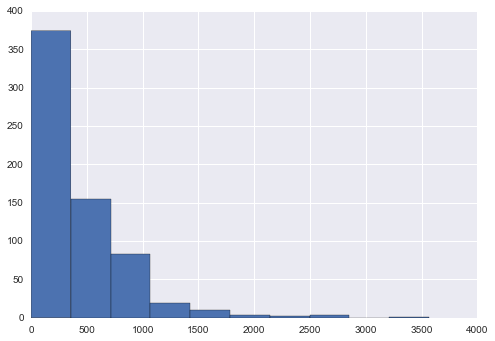

In [27]:
plot_by_index('total_minutes_visited', True)

Non-Passing total_minutes_visited


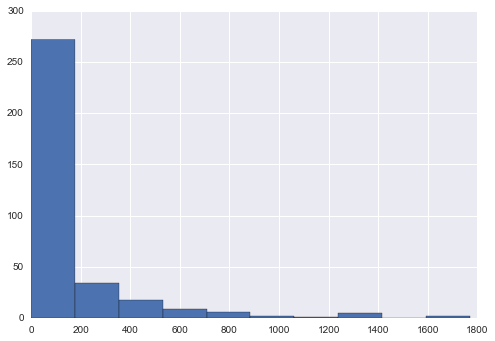

In [28]:
plot_by_index('total_minutes_visited', False)

Passing lessons_completed


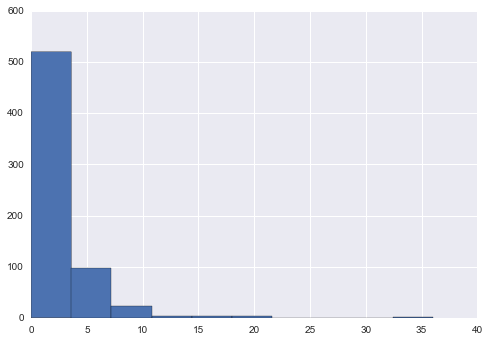

In [29]:
plot_by_index('lessons_completed', True)

Non-Passing lessons_completed


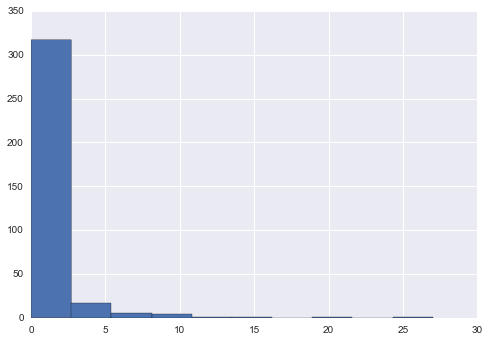

In [30]:
plot_by_index('lessons_completed', False)

Passing has_visited


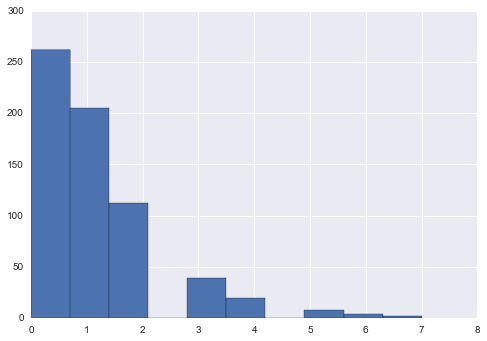

In [31]:
plot_by_index('has_visited', True)

Non-Passing has_visited


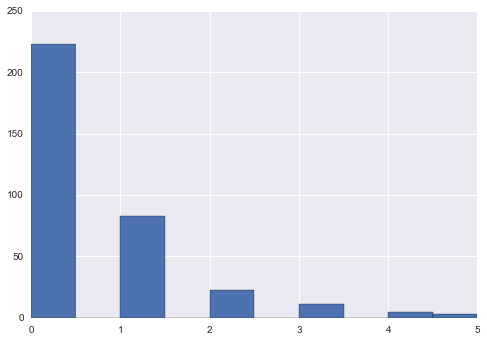

In [32]:
plot_by_index('has_visited', False)

## Improving Plots and Sharing Findings

In [ ]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.